In [22]:
%load_ext autoreload
%autoreload 2

from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
from functions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# VAE

## 1) Train

### Define hyperparams

In [23]:
batch_size = 128
log_interval = 10
epochs = 10
torch.manual_seed(1)

use_cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

### Load train and test data

In [24]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

### Define model

In [25]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

### Train & test

In [52]:
from functions import *

for epoch in range(1, epochs + 1):
    model = train(epoch, model, train_loader, optimizer, loss_function_beta, device)
    test(epoch, model, test_loader, loss_function_beta, batch_size, device, name='betaVAE')
    test(epoch, model, test_loader, loss_function, batch_size, device, name='betaVAE-Bernoulli')

Train Epoch: 1 [0/60000 (0%)]	Loss: -0.001191
Train Epoch: 1 [1280/60000 (2%)]	Loss: -0.001199
Train Epoch: 1 [2560/60000 (4%)]	Loss: -0.001105
Train Epoch: 1 [3840/60000 (6%)]	Loss: -0.001071
Train Epoch: 1 [5120/60000 (9%)]	Loss: -0.001234
Train Epoch: 1 [6400/60000 (11%)]	Loss: -0.001287
Train Epoch: 1 [7680/60000 (13%)]	Loss: -0.001568
Train Epoch: 1 [8960/60000 (15%)]	Loss: -0.001100
Train Epoch: 1 [10240/60000 (17%)]	Loss: -0.001276
Train Epoch: 1 [11520/60000 (19%)]	Loss: -0.001584
Train Epoch: 1 [12800/60000 (21%)]	Loss: -0.001136
Train Epoch: 1 [14080/60000 (23%)]	Loss: -0.001428
Train Epoch: 1 [15360/60000 (26%)]	Loss: -0.001292
Train Epoch: 1 [16640/60000 (28%)]	Loss: -0.001243
Train Epoch: 1 [17920/60000 (30%)]	Loss: -0.001200
Train Epoch: 1 [19200/60000 (32%)]	Loss: -0.001265
Train Epoch: 1 [20480/60000 (34%)]	Loss: -0.001455
Train Epoch: 1 [21760/60000 (36%)]	Loss: -0.001416
Train Epoch: 1 [23040/60000 (38%)]	Loss: -0.001536
Train Epoch: 1 [24320/60000 (41%)]	Loss: -0.001

KeyboardInterrupt: 

### Plot

In [30]:
test_data = list(test_loader)
test_sample_num = len(test_data)
results = []
groups = torch.empty(0)
j = 0
for i in range(test_sample_num):
    labels = test_data[i][1]
    groups = torch.cat((groups, labels))
    
    images = test_data[i][0]
    K = images.shape[0]
    for k in range(K):
        img = images[k,:,:,:]
        img = torch.flatten(img)
        mean_img = model.encode(img)[0] # X,Y
        results.append(mean_img.detach().numpy())
        j +=1

results = np.array(results)

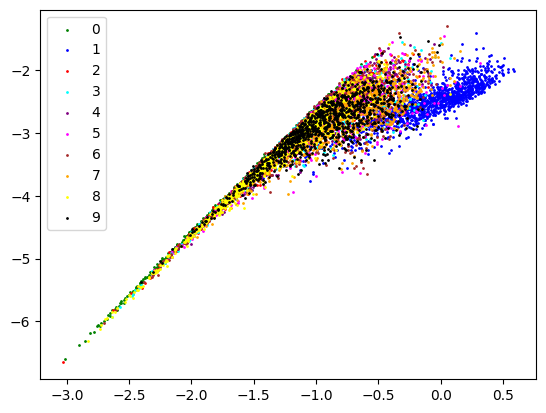

In [31]:
scatter_x = results[:,0]
scatter_y = results[:,1]
colors = ['green', 'blue', 'red', 'cyan', 'purple', 'magenta', 'brown', 'orange', 'yellow', 'black']

fig, ax = plt.subplots()
for g in np.unique(groups):
    g = int(g)
    idx = np.where(groups == g)
    ax.scatter(scatter_x[idx], scatter_y[idx], c=colors[g], label=g, s=1)
    
ax.legend()
plt.savefig('figs/A/betaVAE_2D_Latentspace.png')
plt.show()

## 2) We continue the latent space investigation by evaluating possible outcomes of p(z). As a means to do that, we revisit the inverse Gassian CDF and uniformly distributed samples and its map to a random Normal distribution.: Create a 2D grid of size (k,k) (e.g. torch.linspace, torch.meshgrid) and map through torch.distributions.normal.Normal.icdf to get equally spaced points according to the Gaussian CDF. Create a k,k figure for each entry and plot an image of p(x|z).

/Users/daniel/.miniconda/envs/pyro/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


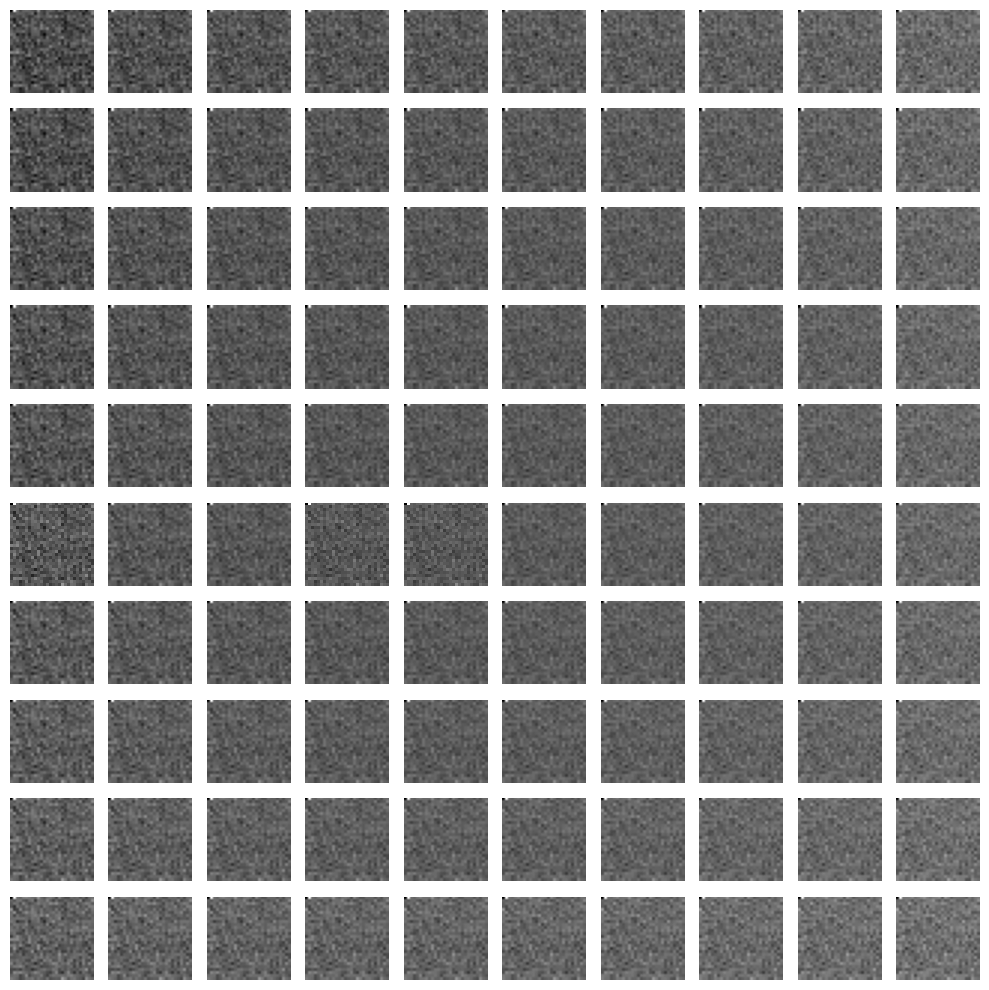

In [32]:
M = 10
x = torch.linspace(start=0, end=1, steps=M+2)[:-1][1:]
mesh_x, mesh_y = torch.meshgrid(x, x)
gauss = torch.distributions.normal.Normal(loc = 0, scale = 1)
gauss_x = gauss.icdf(mesh_x)
gauss_y = gauss.icdf(mesh_y)

fig, ax = plt.subplots(nrows=M, ncols=M, figsize=(10, 10))
for i in range(M):
    for j in range(M):
        _x = gauss_x[i,j].item()
        _y = gauss_y[i,j].item()
        im = model.decode(torch.Tensor([_x, _y]))
        im = im.detach().numpy().reshape((28, 28))
        
        ax[i,j].imshow(im, cmap='gray')
        ax[i,j].axis('off')

plt.tight_layout()
plt.savefig('figs/A/betaVAE_GRID.png')
plt.show()